# CAB420, Encoders and Decoders, Example 4: Variational Auto-Encoders
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

In this example we will  look at a Variational Auto-Encoder. This will learn a latent representation, which we can then sample from to generate new samples, i.e. we can use our VAE to 'make up' new data.

Note, this has been adapted from the Keras VAE example [here](https://keras.io/examples/variational_autoencoder/).

The original VAE paper can be found here if you're interested:
* Kingma, Diederik P., and Max Welling. "Auto-Encoding Variational Bayes." https://arxiv.org/abs/1312.6114

Another good resource (that is slightly lighter reading) is [here](https://ermongroup.github.io/cs228-notes/extras/vae/), or this blog post [here](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf).

## Too Long; Didn't Read:
The main take home messages from this example are:
* Variational Auto-Encoders learn a latent distribution of the input space, rather than just some arbitrary low dimensional representation
* The encoder will learn how to map an input to this latent space
* The decoder will learn how to map from the latent space to the image space
* This means that we can sample from the latent space, and use the decoder to create new samples

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

## Setup and Supporting Functions
   


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose=False)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose=False)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()    

## Setup the Network

This is really just a simple auto-encoder, with one key difference that we'll see in a little bit.

We'll start by setting up our data, where we'll use MNIST for now. If you are interested, I'd encourage you to swap this out for other datasets (fashion-mnist, kmnist) and have a look and a play.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### Network Parameters

Some dimensions and similar parameters to control our network. The one that's really key here is latent_dim, this is how big our latent space is. We've got this very small - really so that we can visualise what our model learns. In practice, this would be bigger (but then it's hard to plot).

In [4]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

### Model Setup

Our model is an autoencoder, so it has:
* An encoder
* A decoder

So far, this sounds straight forward. But our bottleneck is trying to learn a distribution, not just some compact embedding.

The below setup is perhaps slightly muddled as we want to have the encoder and decoder accessible as separate models, even if we are going to learn it all jointly.

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense[0][0]']                  
                                                                                            

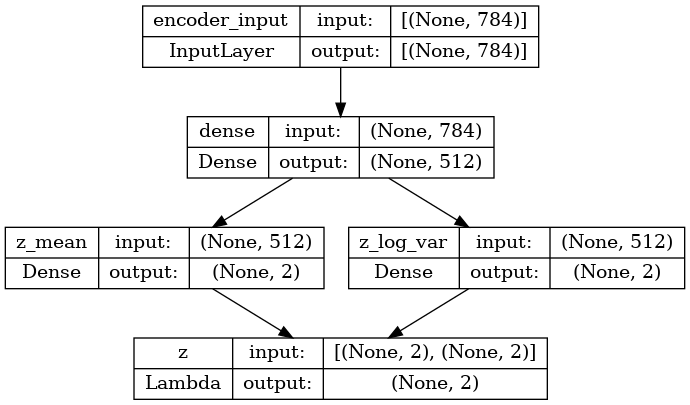

In [5]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


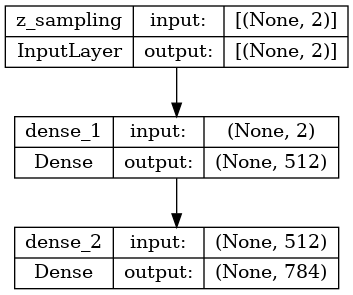

In [6]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True)

Our encoder:
* takes an input image
* outputs a mean and standard deviation, and a sample from that distribution. Basically, it's learning the parameters of the distribution we're trying to model, and drawing a sample from that distribution.

Our decoder:
* takes a random sample (from the encoder)
* outputs an image

### Instantiate VAE model

Chaining it together, the model takes in an image, and outputs an image - but we combine the encoder and decoder by having the input to the decoder being the random sample that is produced by the encoder.

There is a potential problem here is that we now have, in the middle of our network, a random sampling process. How do we back-propogate through random sampling? The short answer is we don't, and we use the sampling function above (the reparameterisation trick) to avoid this. 

The last part of the puzzle is our loss. We have two losses:
* The standard reconstruction loss, which we'd expect given that this is an autoencoder
* KL divergence loss, which is new

As we're trying to learn a distribution, we want to be sure that we do in fact actually learn a distribution. As such, we compare our learned distribution to the unit normal distribution, as we want to encourage our model to use the entire latent space and not just put everything in one corner.

In [7]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          403972      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          403728      ['encoder[0][2]']                
                                                                                            

### Train the Autoencoder

Finally, we can train the model. This is just like we train any other autoencoder now.

In [8]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/50
469/469 [==============================] - 4s 4ms/step - loss: 51.3671 - val_loss: 43.4912
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 42.9508 - val_loss: 42.1697
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 42.0175 - val_loss: 41.5552
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 41.0017 - val_loss: 40.6653
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 40.6589 - val_loss: 40.4217
Epoch 7/50
469/469 [==============================] - 2s 3ms/step - loss: 40.3451 - val_loss: 40.1423
Epoch 8/50
469/469 [==============================] - 1s 3ms/step - loss: 40.0970 - val_loss: 39.9344
Epoch 9/50
469/469 [==============================] - 1s 3ms/step - loss: 39.8689 - val_loss: 39.8304
Epoch 10/50
469/469 [==============================] - 1s 3ms/step - loss: 39.6888 - val_loss: 39.6147
Epoch 11/50
469/469 [==============================] - 1s 3ms/step - loss: 39.487

## The Results

Let's now visualise the results. We'll look at two things:
* How the samples are distributed about the latent space
* What happens when we sample from the latent space

The first of these looks like we'd probably expect. We see semi-distinct clusters for each class, suggesting that we've learned to separate the classes somewhat in the latent space. However it's also not as disjoint as we've seen before. Often when we do one of these plots, we have large lumps of white space in between clusters. Here, while all numbers are (somewhat) distinct, they also lie directly next to each other in the latent space.

The second plot is more interesting. Here we've sampled at fixed intervals from the distribution, and pumped these through the deocder. We can see that we generate samples corresponding to each digit, and we can also see the points at which digits overlap and the model transitions from one to the other.

The third plot is just showing some more detail around the centre of the distribution to make some of the classes and the transitions between them a bit more visible.

From this, we can also see how we could "create" new data simply by sampling randomly from our learned latent space, as every different random sample will give us a slightly different number.

79/79 [==============================] - 0s 1ms/step


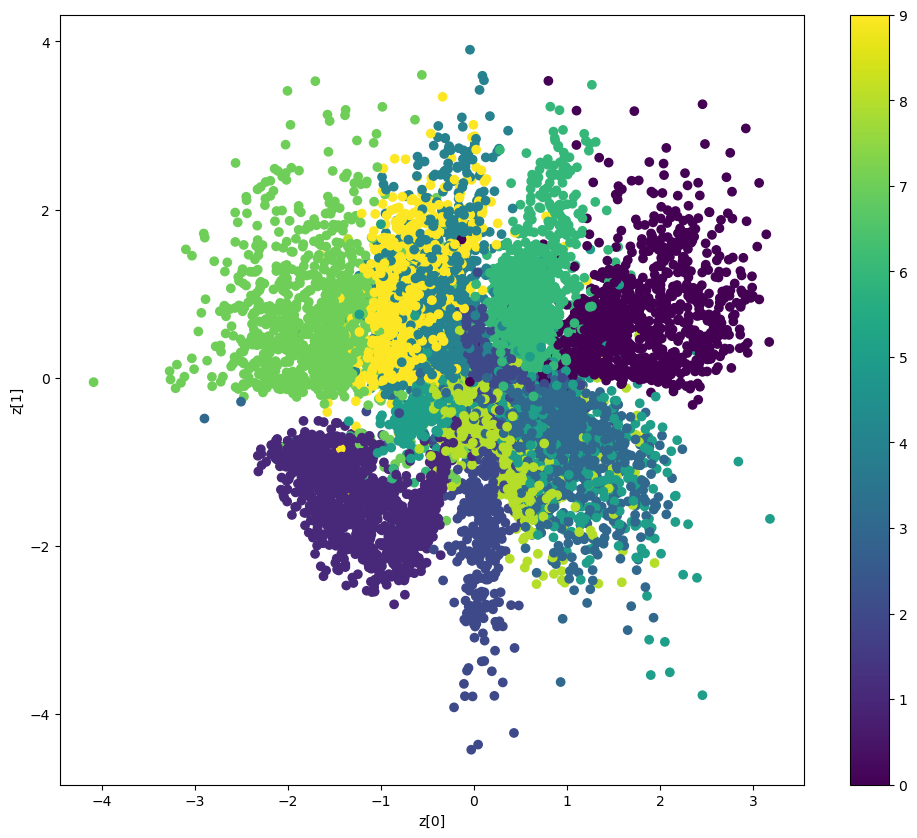

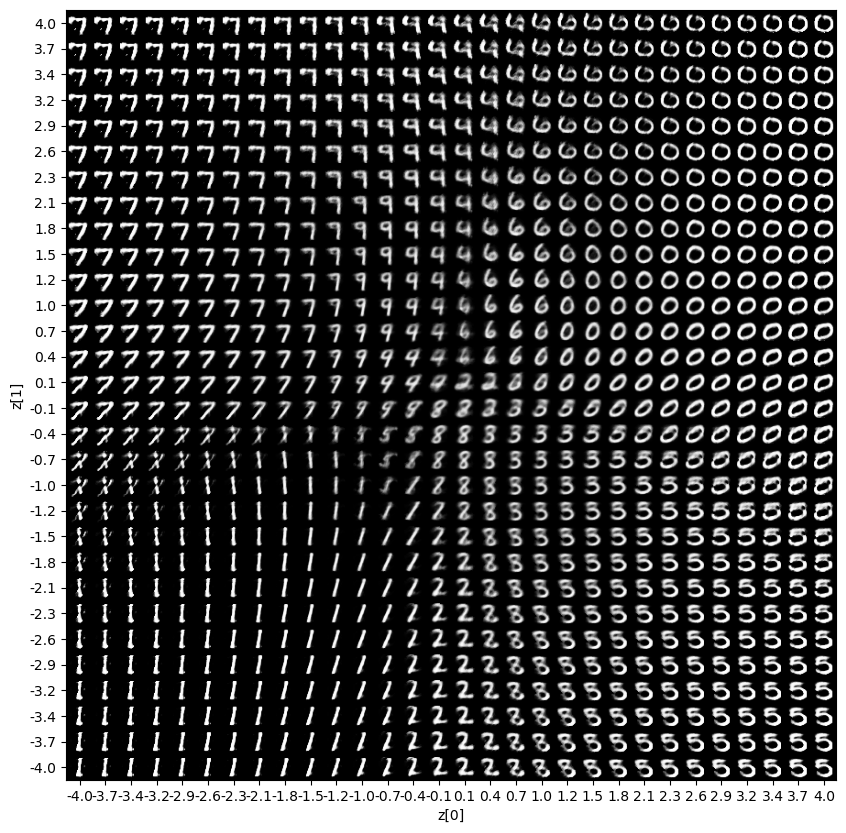

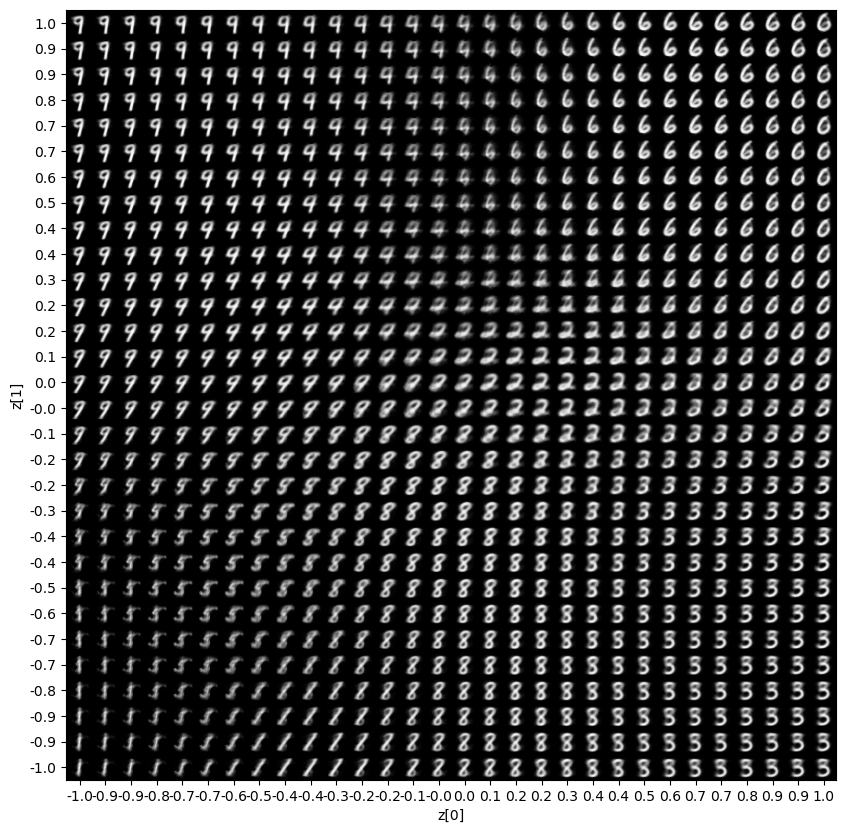

In [9]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

## Final Thoughts

What we've seen is that we can learn more than just a simple embedding, we can actually learn a distribution that characterises the input space. Is this useful? It depends. If your aim is to be able to create realistic data, then it certainly is. If you're using an auto-encoder for compression, or as part of a multi-task learning application, then perhaps not. Nonetheless, its an interesting exploration of what's possible with deep nets.

While this example has been very simple in that we've used just dense layers and a tiny input space, in reality you can use convolutional layers and bigger latent spaces to learn a much richer (and more accurate model), and there is a [Keras example](https://www.tensorflow.org/tutorials/generative/cvae) that demonstrates a convolutional version of this.